In [1]:
!pip install keras

In [2]:
from google.colab import drive

drive.mount("/content/drive")

import pandas as pd
import numpy as np
import io
from pathlib import Path
import shutil
import urllib
import sys
import zipfile
import json

import tqdm
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import os
from typing import List, Callable, Dict

Mounted at /content/drive


# Task 1 Corpus

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

### Download the corpus

In [3]:
def download_url(download_path: Path, url: str):
    urllib.request.urlretrieve(url, filename=download_path)

In [4]:
dataset_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

# print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
if not dataset_zip_path.exists():
    print("Downloading dataset... ", end="")
    download_url(url=dataset_url, download_path=dataset_zip_path)
    print("Download complete!")
else:
    print("Dataset already downloaded!")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_path.exists():
    print("Extracting dataset... (it may take a while...) ", end="")
    shutil.unpack_archive(dataset_zip_path, dataset_folder)
    print("Extraction completed!")
else:
    print("Dataset already extracted!")

Extracting dataset... (it may take a while...) Extraction completed!


#### Encode the corpus into a pandas DataFrame object

In [5]:
folder = dataset_folder.joinpath(dataset_name)


dataframe_rows = []
for file_path in sorted(folder.glob("*.dp")):
    with file_path.open(mode="r", encoding="utf-8") as text_file:
        # Reading the text
        text = text_file.read()
        # Split sentences (\n\n is used for most NLP datasets to split sentences)
        sentences = text.split("\n\n")

        # Observing each sentence
        for s in sentences:
            sentence = []
            tags = []
            # sentence = [pierre,vinken,,aksjdajs, ]. tags = [NNP,aab,asd....]
            # Taking every line
            for line in s.split("\n"):
                columns = line.split("\t")
                # If every line have word, tag, value
                if len(columns) > 2:
                    # Put words and tags into lists
                    sentence.append(columns[0])
                    tags.append(columns[1])

            # Get the File_ID
            file_id = int(file_path.stem.split("_")[1])
            dataframe_row = {"file_id": file_id, "sentence": sentence, "tag": tags}
            dataframe_rows.append(dataframe_row)
# Create the dataframe
df = pd.DataFrame(dataframe_rows)

FILE_ID, WORD, TAG = df.columns.values

In [6]:
df.head()

,file_id,sentence,tag
0,1,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,3,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


#### Splitting Data Train-Test-Validation
Before splitting, lower case convertion is done as a mini preprocessing step. Main preprocessing steps are done later.

#### Lower Case

In [7]:
### Make a list lowercase
def lowercase_list(input_list):
    return [item.lower() for item in input_list]

In [8]:
df["sentence"] = df["sentence"].apply(lowercase_list)

#### Splitting

In [9]:
### file indices for train/validation/test
train_ids = np.arange(1, 101)
val_ids = np.arange(101, 151)
test_ids = np.arange(151, 200)

df_train = df[df[FILE_ID].isin(train_ids)]
df_val = df[df[FILE_ID].isin(val_ids)]
df_test = df[df[FILE_ID].isin(test_ids)]

# Task 2 Text encoding

### Pre-processing

#### Reproducibility

In [10]:
def set_reproducibility(seed):
    random.seed(seed)  # Seed for the Python built-in random module
    np.random.seed(seed)  # Seed for NumPy
    tf.random.set_seed(seed)  # Seed for TensorFlow
    os.environ["TF_DETERMINISTIC_OPS"] = (
        "1"  # Set an environment variable for deterministic TensorFlow operations
    )

#### Hyperparameters for Embedding and First Training Phase

In [11]:
max_sequence_length = int(np.quantile([len(seq) for seq in df_train["sentence"]], 0.99))
hparams = {
    "batch_size": 128,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_sequence_length": max_sequence_length,
    "vocab_size": 7405,
    "tag_size": 46,
}

#### Vocabulary Creation & Tokenization
Keras Tokenizer Class is used for tokenization and vocabulary creation.

In [12]:
### Use Keras Tokenizer to create Vocabulary

tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df_train["sentence"])

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df_train["tag"])


# Turns text into into padded sequences.
def prep_text(texts, tokenizer, max_sequence_length):
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(
        text_sequences, maxlen=max_sequence_length, padding="post"
    )


text_train = prep_text(df_train["sentence"], tokenizer, hparams["max_sequence_length"])
text_test = prep_text(df_test["sentence"], tokenizer, hparams["max_sequence_length"])
text_val = prep_text(df_val["sentence"], tokenizer, hparams["max_sequence_length"])

tag_train = prep_text(df_train["tag"], tag_tokenizer, hparams["max_sequence_length"])
tag_test = prep_text(df_test["tag"], tag_tokenizer, hparams["max_sequence_length"])
tag_val = prep_text(df_val["tag"], tag_tokenizer, hparams["max_sequence_length"])

In [13]:
text_train.shape

(1963, 56)

#### One-Hot-Encoding
One-Hode-Encoding is done to use it in training and evaluation phase.

In [14]:
from keras.utils import to_categorical

num_classes = len(tag_tokenizer.word_index) + 1
y_train = to_categorical(tag_train, num_classes)
y_test = to_categorical(tag_test, num_classes)
y_val = to_categorical(tag_val, num_classes)

#### Tag-Tokens


In [15]:
all_classes = list(tag_tokenizer.word_index.keys())
all_tokens = list(tag_tokenizer.word_index.values())
punct_classes = [",", ".", ":", "``", "''", "$", "#", "sym", "-rrb-", "-lrb-"]
punct_tokens = [tag_tokenizer.word_index[p] for p in punct_classes]
allowed_classes = [
    word for word in tag_tokenizer.index_word.values() if word not in punct_classes
]
allowed_tokens = [token for token in all_tokens if token not in punct_tokens]

print(
    f"Tags: {all_classes}\n"
    + f"All tag-tokens: {all_tokens}\n\n"
    + f"Punctuations: {punct_classes}\n"
    + f"Tokenized punctuations {punct_tokens}\n\n"
    + f"Tags without punctuation: {allowed_classes}\n"
    + f"Tokens will be used in evaluations: {allowed_tokens}"
)

All classes are: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', ',', '.', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', '``', 'pos', "''", '$', ':', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', '-rrb-', '-lrb-', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh', 'sym', '#']
Their translation in token is: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Not Allow token (Punctuation) are: [',', '.', ':', '``', "''", '$', '#', 'sym', '-rrb-', '-lrb-']
Their translation in token is: [7, 8, 26, 22, 24, 25, 45, 44, 35, 36]

Classes without punctuation: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', 'pos', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh']
Their translation in token is: [1, 2, 3, 4, 5, 6, 9, 10

In [16]:
y_train.shape

(1963, 56, 46)

### Embeddings

#### Downloading Pre-Trained Glove Embeddings
This may take a few minutes to complete.

In [17]:
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_file = urllib.request.urlopen(zip_file_url)
archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

#### Creating Embedding Matrix
Downloaded GloVe embeddings were used to create an embedding matrix, where the rows contain the word embeddings for the tokens in the Tokenizer's vocabulary.

In [18]:
embeddings_index = {}
glove_file = "glove.6B.100d.txt"

with archive.open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0].decode("utf-8")
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

In [19]:
### Inspect tokens' embedding vectors
idx_token = 2
print(
    f"Token: {list(tokenizer.word_index.keys())[idx_token]} \nVector: {embedding_matrix[idx_token]}"
)

Token: the 
Vector: [-0.10767     0.11053     0.59811997 -0.54360998  0.67395997  0.10663
  0.038867    0.35481     0.06351    -0.094189    0.15786    -0.81664997
  0.14172     0.21939     0.58504999 -0.52157998  0.22782999 -0.16642
 -0.68228     0.35870001  0.42568001  0.19021     0.91962999  0.57555002
  0.46184999  0.42363    -0.095399   -0.42749    -0.16566999 -0.056842
 -0.29595     0.26036999 -0.26605999 -0.070404   -0.27662     0.15820999
  0.69825     0.43081     0.27952    -0.45436999 -0.33801001 -0.58183998
  0.22363999 -0.57779998 -0.26862001 -0.20424999  0.56393999 -0.58524001
 -0.14365    -0.64218003  0.0054697  -0.35247999  0.16162001  1.1796
 -0.47674    -2.75530005 -0.1321     -0.047729    1.06550002  1.10339999
 -0.2208      0.18669     0.13177     0.15117     0.71310002 -0.35214999
  0.91347998  0.61782998  0.70991999  0.23954999 -0.14571001 -0.37858999
 -0.045959   -0.47367999  0.2385      0.20536    -0.18996     0.32506999
 -1.11119998 -0.36341     0.98679    -0.084

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

## Model Creation
Keras Subclassing method was used while creating the model.


An instance of the CreateModel class represents the model, and its architecture is specified based on the configuration provided.

The model includes:
* An Embedding Layer
* A Bidirectional LSTM Layer
* Optional Bidirectional LSTM Layer
* Optional dense layer.
* Time-distributed Dense Layer

It generates output sequences using a time-distributed dense layer. The architecture is configured through parameters such as vocabulary size, embedding dimension, LSTM units, and additional layers.

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Input,
)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
import tensorflow as tf


class CreateModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()

        vocab_size = config["vocab_size"]
        embedding_dim = config["embedding_dim"]
        max_sequence_length = config["max_sequence_length"]
        embedding_matrix = config["embedding_matrix"]
        tag_size = config["tag_size"]
        lstm_units = config["lstm_units"]
        Additional_LSTM = config["Additional_LSTM"]
        Additional_Dense = config["Additional_Dense"]
        add_lstm_units = config["add_lstm_units"]
        add_dense_units = config["add_dense_units"]

        # Embedding layer
        self.embedding_layer = Embedding(
            vocab_size + 1,
            embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=False,
        )

        # Bidirectional LSTM layer
        self.bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))
        # Additional LSTM
        self.additional_lstm = (
            Bidirectional(LSTM(add_lstm_units, return_sequences=True))
            if Additional_LSTM
            else None
        )
        # Additional Dense
        self.additional_dense = (
            Dense(add_dense_units, activation="relu") if Additional_Dense else None
        )

        # Dense output layer
        self.dense_output = TimeDistributed(Dense(tag_size, activation="softmax"))

    def call(self, inputs):
        # Define the forward pass
        x = self.embedding_layer(inputs)
        x = self.bi_lstm(x)

        # Add the additional LSTM layer if specified
        if self.additional_lstm:
            x = self.additional_lstm(x)

        # Add the additional Dense layer if specified
        if self.additional_dense:
            x = self.additional_dense(x)

        outputs = self.dense_output(x)
        return outputs

    def build(self, shape):
        x = tf.keras.layers.Input(shape=(shape,))
        return tf.keras.Model(inputs=x, outputs=self.call(x))

In [22]:
config_dict = {
    "vocab_size": 7405,
    "embedding_dim": 100,
    "max_sequence_length": max_sequence_length,
    "embedding_matrix": embedding_matrix,
    "tag_size": 46,
    "lstm_units": 64,
    "Additional_LSTM": False,
    "Additional_Dense": False,
    "add_lstm_units": None,
    "add_dense_units": None,
}
# Create an instance of the custom model
custom_model = CreateModel(config_dict).build(config_dict["max_sequence_length"])

# Compile the model
custom_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Print model summary

custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding (Embedding)       (None, 56, 100)           740600    
                                                                 
 bidirectional (Bidirection  (None, 56, 128)           84480     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 56, 46)            5934      
 ributed)                                                        
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
_________________________________________________________________


# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!


### Token to embedding mapping

You can follow two approaches for encoding tokens in your POS tagger.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

## Metrics
For evaluation metrics F1-score function from sklearn library is used. Also Hyperparameter-tuning is done by a grid search function. All models saved to google drive in order to use it later since Google Colab has limited computational units.

### Hyperparameter Tuning & Evaluation
Firstly, layer combinations for each model were taken from layer unit calculator.
In this experiment only the options that "first layerunits < second layerunits" were calculated in order not to exceed the memory limits of the colab. <br>

For example, for the model add_LSTM since layer orders like:<br>
**Input -> BiLSTM-1 -> BiLSTM-2 -> Timedistributed**
<br>BiLSTM-2 # units are selected greater or equal than BiLSTM-1 <br>

Then, Grid-Search algorithm was run.



In [23]:
# Get Layer Unit Combinations for Hyperparameter Tuning
# Since all cambinations costs a lot of memory, only the options that "first layerunits < second layerunits" are calculated.
def layer_unit_calculator(max_units):
    base_units = [64, 128, 256, 512]
    for i in base_units.copy():
        if i > max_units:
            base_units.remove(i)

    # Generate all possible two-element combinations
    # Convert the resulting iterator to a list
    layer_units = [(x, y) for x in base_units for y in base_units if x <= y]

    return base_units, layer_units

#### Directories for saving the models and results

In [17]:
models_path = "/content/drive/MyDrive/NLP_Assignment1/Models/"
scores_path = "/content/drive/MyDrive/NLP_Assignment1/Scores/"

os.makedirs(models_path, exist_ok=True)
os.makedirs(scores_path, exist_ok=True)

#### Grid Search

The function:

*   Iterates through all given combinations and 3 random seeds.
*   Sets the model name in according to given parameters dictionary.
*   Creates the models and get the scores of each.
*   Saves the models into a given directory
*   Saves the scores in json format.
*   Returns scores in a list.



In [26]:
from sklearn.metrics import f1_score


def grid_search(parameters, max_units, callbacks, seed_list):
    models_list = {}
    baseline_units, layer_units = layer_unit_calculator(max_units)
    for seed in seed_list:
        # In order to get exact same weights set the seed at the start of each iteration
        set_reproducibility(seed)
        for i in (
            layer_units
            if (parameters["Additional_LSTM"] or parameters["Additional_Dense"])
            else baseline_units
        ):
            if parameters["Additional_LSTM"]:
                print("HERE2")
                parameters["lstm_units"] = i[0]
                parameters["add_lstm_units"] = i[1]
                custom_model_name = f"LSTM_added_{i[0]}_{i[1]}"
                score_dict_name = "LSTM_added"
            elif parameters["Additional_Dense"]:
                parameters["lstm_units"] = i[0]
                parameters["add_dense_units"] = i[1]
                custom_model_name = f"Dense_added_{i[0]}_{i[1]}"
                score_dict_name = "Dense_added"
            else:
                parameters["lstm_units"] = i
                custom_model_name = f"Baseline_{i}"
                score_dict_name = "Baseline"

            # Create an instance of the custom model
            custom_model = CreateModel(parameters).build(
                parameters["max_sequence_length"]
            )

            # Compile the model
            custom_model.compile(
                optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
            )

            # Print model summary
            custom_model.summary()

            history = custom_model.fit(
                text_train,
                y_train,
                batch_size=64,
                epochs=50,
                validation_data=(text_val, y_val),
                verbose=1,
                callbacks=[callbacks],
            )

            # Save the model
            custom_model.save(f"{models_path}{custom_model_name}.hdf5")

            y_pred = custom_model.predict([text_val]).argmax(-1).flatten()
            y_test_flatten = y_val.argmax(-1).flatten()
            score = f1_score(
                y_test_flatten,
                y_pred,
                labels=allowed_tokens,
                average="macro",
                zero_division=0,
            )
            models_list = store_result(custom_model_name, models_list, score)
            print(f"F1 score: {score}")

    # Save scores to a json file
    json_data = json.dumps(models_list)
    file_path = f"{scores_path}{score_dict_name}.json"
    with open(file_path, "w") as file:
        file.write(json_data)

    return models_list


def store_result(model_name, results_dict, score):
    if model_name not in results_dict:
        # If not, create a new key with an empty list as its value
        results_dict[model_name] = []

    # Append the score to the list associated with the key
    results_dict[model_name].append(score)
    return results_dict

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

## Training and Evaluation
For each configuration, a custom neural network model was built, compiled, and trained on the training data.

The training progress was stored, and the resulting model was saved. The F1 score was then calculated on the validation data, and the scores were stored in a dictionary (models_list).

Finally, the dictionary was serialized to a JSON file, and the function returns the dictionary containing F1 scores for different model configurations.

#### Early Stopping Configuration

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=7, restore_best_weights=True
)
seed_list = random.sample(range(1, 1000), 3)

#### Baseline Models Training

In [28]:
config_dict = {
    "vocab_size": 7405,
    "embedding_dim": 100,
    "max_sequence_length": max_sequence_length,
    "embedding_matrix": embedding_matrix,
    "tag_size": 46,
    "lstm_units": 64,
    "Additional_LSTM": False,
    "Additional_Dense": False,
    "add_lstm_units": None,
    "add_dense_units": None,
}
baseline_models = grid_search(config_dict, 256, early_stopping, seed_list)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_1 (Bidirecti  (None, 56, 128)           84480     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 56, 46)            5934      
 stributed)                                                      
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
_________________________________________________________________
Epoch 1/50
31/31 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.7029175886108544
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_2 (Bidirecti  (None, 56, 256)           234496    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 56, 46)            11822     
 stributed)                                                      
                                                                 
Total params: 986918 (3.76 MB)
Trainable params: 246318 (962.18 KB)
Non-trainable params: 740600 (2.83 MB)
__

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.711689505598306
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_3 (Bidirecti  (None, 56, 512)           731136    
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 56, 46)            23598     
 stributed)                                                      
                                                                 
Total params: 1495334 (5.70 MB)
Trainable params: 754734 (2.88 MB)
Non-trainable params: 740600 (2.83 MB)
____

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.7101639256511849
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_4 (Bidirecti  (None, 56, 128)           84480     
 onal)                                                           
                                                                 
 time_distributed_4 (TimeDi  (None, 56, 46)            5934      
 stributed)                                                      
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
___

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.7046671009140955
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_5 (Bidirecti  (None, 56, 256)           234496    
 onal)                                                           
                                                                 
 time_distributed_5 (TimeDi  (None, 56, 46)            11822     
 stributed)                                                      
                                                                 
Total params: 986918 (3.76 MB)
Trainable params: 246318 (962.18 KB)
Non-trainable params: 740600 (2.83 MB)
__

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.7109374732566758
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_6 (Bidirecti  (None, 56, 512)           731136    
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (None, 56, 46)            23598     
 stributed)                                                      
                                                                 
Total params: 1495334 (5.70 MB)
Trainable params: 754734 (2.88 MB)
Non-trainable params: 740600 (2.83 MB)
___

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7214397855549428
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_7 (Bidirecti  (None, 56, 128)           84480     
 onal)                                                           
                                                                 
 time_distributed_7 (TimeDi  (None, 56, 46)            5934      
 stributed)                                                      
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
___

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.6857402097972906
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_8 (Bidirecti  (None, 56, 256)           234496    
 onal)                                                           
                                                                 
 time_distributed_8 (TimeDi  (None, 56, 46)            11822     
 stributed)                                                      
                                                                 
Total params: 986918 (3.76 MB)
Trainable params: 246318 (962.18 KB)
Non-trainable params: 740600 (2.83 MB)
__

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.7219565483686943
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 56, 100)           740600    
                                                                 
 bidirectional_9 (Bidirecti  (None, 56, 512)           731136    
 onal)                                                           
                                                                 
 time_distributed_9 (TimeDi  (None, 56, 46)            23598     
 stributed)                                                      
                                                                 
Total params: 1495334 (5.70 MB)
Trainable params: 754734 (2.88 MB)
Non-trainable params: 740600 (2.83 MB)
___

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 7ms/step
F1 score: 0.7223669060318997


#### Additional LSTM (Model1) Models Training

In [29]:
config_dict = {
    "vocab_size": 7405,
    "embedding_dim": 100,
    "max_sequence_length": max_sequence_length,
    "embedding_matrix": embedding_matrix,
    "tag_size": 46,
    "lstm_units": 64,
    "Additional_LSTM": True,
    "Additional_Dense": False,
    "add_lstm_units": None,
    "add_dense_units": None,
}
add_LSTM_models = grid_search(config_dict, 256, early_stopping, seed_list)

HERE2
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_10 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 56, 128)           98816     
 ional)                                                          
                                                                 
 time_distributed_10 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.6770471307222377
HERE2
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_12 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 56, 256)           263168    
 ional)                                                          
                                                                 
 time_distributed_11 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7306825592940475
HERE2
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_14 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 56, 512)           788480    
 ional)                                                          
                                                                 
 time_distributed_12 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.7123520508705481
HERE2
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_16 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 56, 256)           394240    
 ional)                                                          
                                                                 
 time_distributed_13 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.7121706927647037
HERE2
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_18 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_19 (Bidirect  (None, 56, 512)           1050624   
 ional)                                                          
                                                                 
 time_distributed_14 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7207889243623036
HERE2
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_20 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 bidirectional_21 (Bidirect  (None, 56, 512)           1574912   
 ional)                                                          
                                                                 
 time_distributed_15 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 8ms/step
F1 score: 0.7062310566516037
HERE2
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_16 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_22 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_23 (Bidirect  (None, 56, 128)           98816     
 ional)                                                          
                                                                 
 time_distributed_16 (TimeD  (None, 56, 46)            5934      
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 8ms/step
F1 score: 0.6931560397624378
HERE2
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_17 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_24 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_25 (Bidirect  (None, 56, 256)           263168    
 ional)                                                          
                                                                 
 time_distributed_17 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 7ms/step
F1 score: 0.7027788198589459
HERE2
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_18 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_26 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 56, 512)           788480    
 ional)                                                          
                                                                 
 time_distributed_18 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.7099805306658236
HERE2
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_28 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_29 (Bidirect  (None, 56, 256)           394240    
 ional)                                                          
                                                                 
 time_distributed_19 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 8ms/step
F1 score: 0.7156108095728109
HERE2
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_20 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_30 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_31 (Bidirect  (None, 56, 512)           1050624   
 ional)                                                          
                                                                 
 time_distributed_20 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.7154139247640898
HERE2
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_21 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_32 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 bidirectional_33 (Bidirect  (None, 56, 512)           1574912   
 ional)                                                          
                                                                 
 time_distributed_21 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 10ms/step
F1 score: 0.7124745592127728
HERE2
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_22 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_34 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_35 (Bidirect  (None, 56, 128)           98816     
 ional)                                                          
                                                                 
 time_distributed_22 (TimeD  (None, 56, 46)            5934      
 istributed)                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.6722408764401449
HERE2
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_23 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_36 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_37 (Bidirect  (None, 56, 256)           263168    
 ional)                                                          
                                                                 
 time_distributed_23 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 7ms/step
F1 score: 0.6875961853408018
HERE2
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_24 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_38 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 bidirectional_39 (Bidirect  (None, 56, 512)           788480    
 ional)                                                          
                                                                 
 time_distributed_24 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.7156722569507327
HERE2
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_25 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_40 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_41 (Bidirect  (None, 56, 256)           394240    
 ional)                                                          
                                                                 
 time_distributed_25 (TimeD  (None, 56, 46)            11822     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 8ms/step
F1 score: 0.7234218957893922
HERE2
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_42 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 bidirectional_43 (Bidirect  (None, 56, 512)           1050624   
 ional)                                                          
                                                                 
 time_distributed_26 (TimeD  (None, 56, 46)            23598     
 istributed)                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 9ms/step
F1 score: 0.715383510822843
HERE2
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_27 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_44 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 bidirectional_45 (Bidirect  (None, 56, 512)           1574912   
 ional)                                                          
                                                                 
 time_distributed_27 (TimeD  (None, 56, 46)            23598     
 istributed)                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 11ms/step
F1 score: 0.7160128814000507


#### Additional Dense (Model2) Models Training

In [30]:
config_dict = {
    "vocab_size": 7405,
    "embedding_dim": 100,
    "max_sequence_length": max_sequence_length,
    "embedding_matrix": embedding_matrix,
    "tag_size": 46,
    "lstm_units": 64,
    "Additional_LSTM": False,
    "Additional_Dense": True,
    "add_lstm_units": None,
    "add_dense_units": None,
}
add_Dense_models = grid_search(config_dict, 256, early_stopping, seed_list)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_28 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_46 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_28 (Dense)            (None, 56, 64)            8256      
                                                                 
 time_distributed_28 (TimeD  (None, 56, 46)            2990      
 istributed)                                                     
                                                                 
Total params: 836326 (3.19 MB)
Trainable params: 95726 (37

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.6632351913474519
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_29 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_47 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_30 (Dense)            (None, 56, 128)           16512     
                                                                 
 time_distributed_29 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 7ms/step
F1 score: 0.7114856074991359
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_30 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_48 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_32 (Dense)            (None, 56, 256)           33024     
                                                                 
 time_distributed_30 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7162909573491103
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_31 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_49 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_34 (Dense)            (None, 56, 128)           32896     
                                                                 
 time_distributed_31 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7064411021840371
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_32 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_50 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_36 (Dense)            (None, 56, 256)           65792     
                                                                 
 time_distributed_32 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7135147715737818
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_33 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_51 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 dense_38 (Dense)            (None, 56, 256)           131328    
                                                                 
 time_distributed_33 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.6994246650053179
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_34 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_52 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_40 (Dense)            (None, 56, 64)            8256      
                                                                 
 time_distributed_34 (TimeD  (None, 56, 46)            2990      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.6815536146157525
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_35 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_53 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_42 (Dense)            (None, 56, 128)           16512     
                                                                 
 time_distributed_35 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7010449653314907
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_36 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_54 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_44 (Dense)            (None, 56, 256)           33024     
                                                                 
 time_distributed_36 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 7ms/step
F1 score: 0.6902119386741483
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_37 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_55 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_46 (Dense)            (None, 56, 128)           32896     
                                                                 
 time_distributed_37 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.7270953511027339
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_38 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_56 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_48 (Dense)            (None, 56, 256)           65792     
                                                                 
 time_distributed_38 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.7048540694939437
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_39 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_57 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 dense_50 (Dense)            (None, 56, 256)           131328    
                                                                 
 time_distributed_39 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2s 8ms/step
F1 score: 0.7113180297332464
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_40 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_58 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_52 (Dense)            (None, 56, 64)            8256      
                                                                 
 time_distributed_40 (TimeD  (None, 56, 46)            2990      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 4ms/step
F1 score: 0.6914096554289769
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_41 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_59 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_54 (Dense)            (None, 56, 128)           16512     
                                                                 
 time_distributed_41 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7133271064706523
Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_42 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_60 (Bidirect  (None, 56, 128)           84480     
 ional)                                                          
                                                                 
 dense_56 (Dense)            (None, 56, 256)           33024     
                                                                 
 time_distributed_42 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 5ms/step
F1 score: 0.7153965428899632
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_43 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_61 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_58 (Dense)            (None, 56, 128)           32896     
                                                                 
 time_distributed_43 (TimeD  (None, 56, 46)            5934      
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7091769172329901
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_44 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_62 (Bidirect  (None, 56, 256)           234496    
 ional)                                                          
                                                                 
 dense_60 (Dense)            (None, 56, 256)           65792     
                                                                 
 time_distributed_44 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7243867102015679
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 56)]              0         
                                                                 
 embedding_45 (Embedding)    (None, 56, 100)           740600    
                                                                 
 bidirectional_63 (Bidirect  (None, 56, 512)           731136    
 ional)                                                          
                                                                 
 dense_62 (Dense)            (None, 56, 256)           131328    
                                                                 
 time_distributed_45 (TimeD  (None, 56, 46)            11822     
 istributed)                                                     
                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 6ms/step
F1 score: 0.7037979708373858


#### Results of All Models

In [31]:
print(
    f"Baseline Models: {baseline_models} \n\nAdd LSTM Models: {add_LSTM_models}  \n\nAdd Dense Models: {add_Dense_models} "
)

Baseline Models: {'Baseline_64': [0.7029175886108544, 0.7046671009140955, 0.6857402097972906], 'Baseline_128': [0.711689505598306, 0.7109374732566758, 0.7219565483686943], 'Baseline_256': [0.7101639256511849, 0.7214397855549428, 0.7223669060318997]} 

Add LSTM Models: {'LSTM_added_64_64': [0.6770471307222377, 0.6931560397624378, 0.6722408764401449], 'LSTM_added_64_128': [0.7306825592940475, 0.7027788198589459, 0.6875961853408018], 'LSTM_added_64_256': [0.7123520508705481, 0.7099805306658236, 0.7156722569507327], 'LSTM_added_128_128': [0.7121706927647037, 0.7156108095728109, 0.7234218957893922], 'LSTM_added_128_256': [0.7207889243623036, 0.7154139247640898, 0.715383510822843], 'LSTM_added_256_256': [0.7062310566516037, 0.7124745592127728, 0.7160128814000507]}  

Add Dense Models: {'Dense_added_64_64': [0.6632351913474519, 0.6815536146157525, 0.6914096554289769], 'Dense_added_64_128': [0.7114856074991359, 0.7010449653314907, 0.7133271064706523], 'Dense_added_64_256': [0.7162909573491103,

#### Loading Scores

In [18]:
## Load Scores - OPTIONAL
def load_scores(file_path):
    with open(file_path, "r") as file:
        data = file.read()
        return json.loads(data)


# Update file paths based on your Colab environment
baseline_path = "/content/drive/MyDrive/NLP_Assignment1/Scores/Baseline.json"
lstm_path = "/content/drive/MyDrive/NLP_Assignment1/Scores/LSTM_added.json"
dense_path = "/content/drive/MyDrive/NLP_Assignment1/Scores/Dense_added.json"

# Load scores
baseline_models = load_scores(baseline_path)
add_LSTM_models = load_scores(lstm_path)
add_Dense_models = load_scores(dense_path)

# Print results
print(
    f"All scores loaded. \nBaseline Models: {baseline_models}\n\nAdd LSTM Models: {add_LSTM_models}\n\nAdd Dense Models: {add_Dense_models}"
)

Baseline Models: {'Baseline_64': [0.7029175886108544, 0.7046671009140955, 0.6857402097972906], 'Baseline_128': [0.711689505598306, 0.7109374732566758, 0.7219565483686943], 'Baseline_256': [0.7101639256511849, 0.7214397855549428, 0.7223669060318997]}

Add LSTM Models: {'LSTM_added_64_64': [0.6770471307222377, 0.6931560397624378, 0.6722408764401449], 'LSTM_added_64_128': [0.7306825592940475, 0.7027788198589459, 0.6875961853408018], 'LSTM_added_64_256': [0.7123520508705481, 0.7099805306658236, 0.7156722569507327], 'LSTM_added_128_128': [0.7121706927647037, 0.7156108095728109, 0.7234218957893922], 'LSTM_added_128_256': [0.7207889243623036, 0.7154139247640898, 0.715383510822843], 'LSTM_added_256_256': [0.7062310566516037, 0.7124745592127728, 0.7160128814000507]}

Add Dense Models: {'Dense_added_64_64': [0.6632351913474519, 0.6815536146157525, 0.6914096554289769], 'Dense_added_64_128': [0.7114856074991359, 0.7010449653314907, 0.7133271064706523], 'Dense_added_64_256': [0.7162909573491103, 0.

#### Computing Average Performance
Since all models trained with 3 seeds, in order to get the best model, averages and standard deviations of the scores were calculated.

In [19]:
import numpy as np


def compute_average_performance(model_results):
    average_results = {}
    averages = {}

    for model_name, metrics_list in model_results.items():
        # Convert the list of metrics to a NumPy array for easy computation
        metrics_array = np.array(metrics_list)

        # Compute average and standard deviation along the axis of different seeds (axis=0)
        average_accuracy = np.mean(metrics_array, axis=0)
        std_dev_accuracy = np.std(metrics_array, axis=0)

        # Convert NumPy float to Python float before creating a list
        average_accuracy = float(average_accuracy)
        std_dev_accuracy = float(std_dev_accuracy)

        # Store the results in the dictionary
        average_results[model_name + "_average"] = [average_accuracy]
        averages[model_name] = average_accuracy
        average_results[model_name + "_std_dev"] = [std_dev_accuracy]

    return average_results, averages


all_models_avg = {**baseline_models, **add_LSTM_models, **add_Dense_models}
baseline_models_avg = {**baseline_models}
add_lstm_avg = {**add_LSTM_models}
add_dense_avg = {**add_Dense_models}

# Average Results -> gives both std_divs and averages
# Averages -> gives only averages
average_results, averages = compute_average_performance(all_models_avg)

# For Baseline
average_results_baseline, averages_baseline = compute_average_performance(
    baseline_models_avg
)

# For Additional Lstm
average_results_lstm, averages_lstm = compute_average_performance(add_lstm_avg)

# For Additional Dense
average_results_dense, averages_dense = compute_average_performance(add_dense_avg)

# Print results
print("\u0332".join("Results:"))
for model_name, metrics in average_results.items():
    print(f"{model_name}: {metrics}")

R̲e̲s̲u̲l̲t̲s̲:
Baseline_64_average: [0.6977749664407469]
Baseline_64_std_dev: [0.008539778448539466]
Baseline_128_average: [0.7148611757412254]
Baseline_128_std_dev: [0.00502657091217534]
Baseline_256_average: [0.7179902057460091]
Baseline_256_std_dev: [0.0055469440948255205]
LSTM_added_64_64_average: [0.6808146823082734]
LSTM_added_64_64_std_dev: [0.00894452711306854]
LSTM_added_64_128_average: [0.7070191881645984]
LSTM_added_64_128_std_dev: [0.017843662696420043]
LSTM_added_64_256_average: [0.7126682794957014]
LSTM_added_64_256_std_dev: [0.0023343717831722354]
LSTM_added_128_128_average: [0.7170677993756356]
LSTM_added_128_128_std_dev: [0.00470740599763404]
LSTM_added_128_256_average: [0.7171954533164122]
LSTM_added_128_256_std_dev: [0.002540998080833672]
LSTM_added_256_256_average: [0.7115728324214757]
LSTM_added_256_256_std_dev: [0.004043996147124759]
Dense_added_64_64_average: [0.6787328204640605]
Dense_added_64_64_std_dev: [0.011673838737534765]
Dense_added_64_128_average: [0.70

In [20]:
# Print only averages in order to pick best n models
print("\u0332".join("Averages:"))
for model_name, metrics in averages.items():
    print(f"{model_name}: {metrics}")

A̲v̲e̲r̲a̲g̲e̲s̲:
Baseline_64: 0.6977749664407469
Baseline_128: 0.7148611757412254
Baseline_256: 0.7179902057460091
LSTM_added_64_64: 0.6808146823082734
LSTM_added_64_128: 0.7070191881645984
LSTM_added_64_256: 0.7126682794957014
LSTM_added_128_128: 0.7170677993756356
LSTM_added_128_256: 0.7171954533164122
LSTM_added_256_256: 0.7115728324214757
Dense_added_64_64: 0.6787328204640605
Dense_added_64_128: 0.7086192264337597
Dense_added_64_256: 0.7072998129710739
Dense_added_128_128: 0.7142377901732537
Dense_added_128_256: 0.7142518504230978
Dense_added_256_256: 0.7048468885253167


#### Plot Average F1-Scores
In order to select the best model averages of F1-scores were used in this assignment.

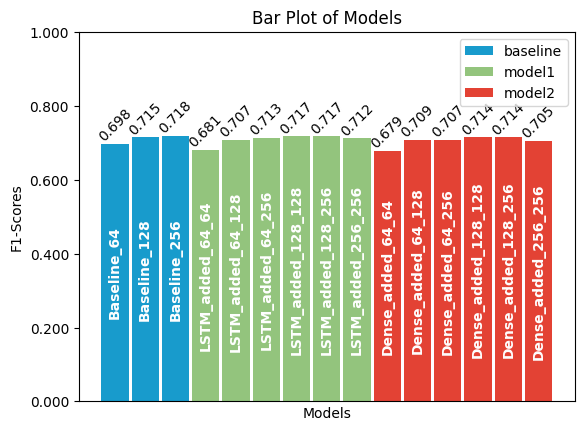

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


def plot_f1_scores(averages_baseline, averages_lstm, averages_dense):
    # Extract keys and values from each dictionary
    keys1, values1 = zip(*averages_baseline.items())
    keys2, values2 = zip(*averages_lstm.items())
    keys3, values3 = zip(*averages_dense.items())

    bar_width = 0.9

    # Plot each dictionary separately
    plt.bar(keys1, values1, label="baseline", color="#189bcc", width=bar_width)
    plt.bar(keys2, values2, label="model1", color="#93c47d", width=bar_width)
    plt.bar(keys3, values3, label="model2", color="#e34234", width=bar_width)

    plt.xticks([])
    # Annotate values above and inside of each bar
    for key, value in zip(keys1, values1):
        plt.text(key, value, f"{value:.3f}", ha="center", va="bottom", rotation=45)
        plt.text(
            key,
            value / 2,
            f"{key}",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            rotation=90,
        )
    for key, value in zip(keys2, values2):
        plt.text(key, value, f"{value:.3f}", ha="center", va="bottom", rotation=45)
        plt.text(
            key,
            value / 2,
            f"{key}",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            rotation=90,
        )
    for key, value in zip(keys3, values3):
        plt.text(key, value, f"{value:.3f}", ha="center", va="bottom", rotation=45)
        plt.text(
            key,
            value / 2,
            f"{key}",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            rotation=90,
        )

    # Add labels and legend
    plt.xlabel("Models")
    plt.ylabel("F1-Scores")
    plt.title("Bar Plot of Models")
    plt.legend()
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.3f}"))
    plt.ylim(0, 1)

    # Show the plot
    plt.show()


plot_f1_scores(averages_baseline, averages_lstm, averages_dense)

#### Pick The Best Model
Optionally, user can get top n models.

In [22]:
# Function for obtaining the best 'n' models according to averages
def get_top_n_models(scores_dict, n):
    sorted_models = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)
    top_n_models = [model_name for model_name, _ in sorted_models[:n]]
    return top_n_models

In [24]:
# Load best n models from models_path
def load_top_models(top_n_models):
    loaded_models = {}
    for model_name in top_n_models:
        loaded = load_model((f"{models_path}{model_name}.hdf5"))
        loaded_models[model_name] = loaded
    return loaded_models

In [25]:
# Get the best model
top_n_models = get_top_n_models(averages, 1)
model_loaded = load_top_models(top_n_models)

best_model = list(model_loaded.keys())

# Get model
first_model = model_loaded[best_model[0]]

print(f"Best Model: {best_model}")

['Baseline_256']


#### Get Prediction


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

## Error Analysis

#### Prediction

In [26]:
# Prediction for the test set
y_pred_test = first_model.predict([text_test]).argmax(-1)
y_test = y_test.argmax(-1)

# Prediction for the validation set
y_pred_val = first_model.predict([text_val]).argmax(-1)
y_test_val = y_val.argmax(-1)

41/41 [==============================] - 6s 154ms/step


#### Visualize Data Distribution
The data distribution was visualized to observe the most and least frequent classes in the validation and test sets.

In [220]:
def get_data_distribution(data):
    """
    Takes the input data and computes the distribution of unique elements along with their counts.

    Parameters:
    - data (iterable): Input data containing elements to be counted.

    Returns:
    A dictionary containing tags (converted to tokens) and their corresponding counts.
    """
    unique, counts = np.unique(data, return_counts=True)
    counts = dict(zip(unique, counts))
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=False))

    # If the tag_token is not allowed deletes it.
    for key in unique:
        if key not in allowed_tokens:
            del counts[key]
    labels = [tag_tokenizer.index_word[index] for index in counts.keys()]
    result = dict(zip(labels, counts.values()))
    return result

In [221]:
def plot_data_distribution(data, name):
    counts = get_data_distribution(data)
    keys = list(counts.keys())
    values = list(counts.values())
    fig = plt.figure(figsize=(6, 6))
    plt.barh(keys, values, color="#902e59")
    plt.title(f"Class Distribution of {name}")
    plt.ylabel("Tags")
    plt.xlabel("Count")
    plt.tick_params(labelsize=8)
    plt.show()

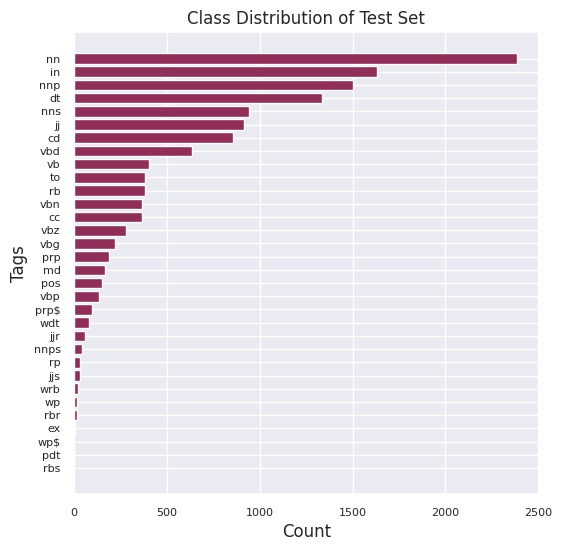

In [222]:
plot_data_distribution(y_test, name="Test Set")

here
here2


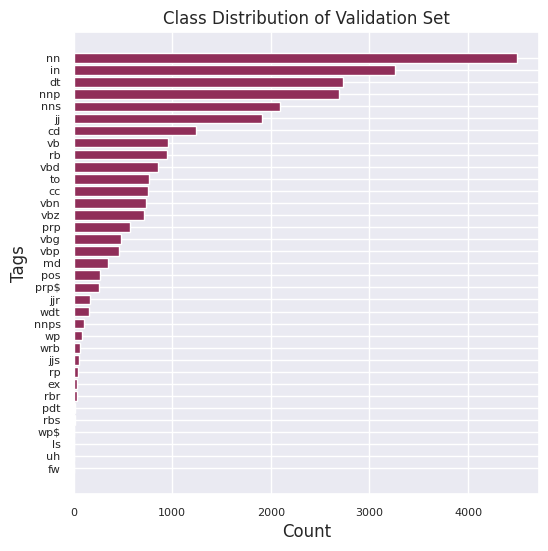

In [219]:
plot_data_distribution(y_test_val, name="Validation Set")

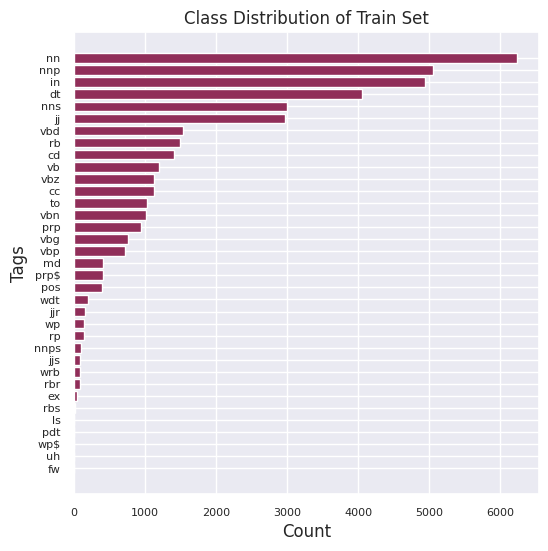

In [266]:
y_train_dist = y_train.argmax(-1)
plot_data_distribution(y_train_dist, name="Train Set")

#### F1 Score Calculation & Classification Report

In [248]:
# Display classification report for the Test Set
cf_report_test = pd.DataFrame(
    classification_report(
        y_pred_test.flatten(),
        y_test.flatten(),
        labels=all_tokens,
        target_names=all_classes,
        zero_division=0,
        output_dict=True,
    )
).transpose()
cf_report_test.reset_index(inplace=True)
cf_report_test.columns = ["tags", "precision", "recall", "f1-score", "support"]


print(
    "F1 score calculated on test set:",
    f1_score(
        y_pred_test.flatten(),
        y_test.flatten(),
        labels=allowed_tokens,
        zero_division=0,
        average="macro",
    ),
    "\n",
)

display(cf_report_test)

F1 score calculated on test set: 0.7464920639758378 



,tags,precision,recall,f1-score,support
0,nn,0.809064,0.831034,0.819902,2320.0
1,nnp,0.841545,0.729792,0.781694,1732.0
2,in,0.952761,0.968808,0.960718,1603.0
3,dt,0.988006,0.984317,0.986158,1339.0
4,nns,0.800213,0.808808,0.804487,931.0
5,jj,0.725490,0.678899,0.701422,981.0
6,",",1.000000,1.000000,1.000000,787.0
7,.,1.000000,0.998435,0.999217,639.0
8,vbd,0.883281,0.881890,0.882585,635.0
9,rb,0.761155,0.794521,0.777480,365.0


In [250]:
# Display classification report for the Validation Set
cf_report_val = pd.DataFrame(
    classification_report(
        y_pred_val.flatten(),
        y_test_val.flatten(),
        labels=all_tokens,
        target_names=all_classes,
        zero_division=0,
        output_dict=True,
    )
).transpose()
cf_report_val.reset_index(inplace=True)
cf_report_val.columns = ["tags", "precision", "recall", "f1-score", "support"]

print(
    "F1 score calculated on validation set:",
    f1_score(
        y_pred_val.flatten(),
        y_test_val.flatten(),
        labels=all_tokens,
        zero_division=0,
        average="macro",
    ),
    "\n",
)
display(cf_report_val)

F1 score calculated on validation set: 0.7223669060318997 



,tags,precision,recall,f1-score,support
0,nn,0.830848,0.800043,0.815154,4666.0
1,nnp,0.834076,0.693733,0.757458,3239.0
2,in,0.961338,0.977535,0.969369,3205.0
3,dt,0.985375,0.985375,0.985375,2735.0
4,nns,0.763497,0.822440,0.791873,1943.0
5,jj,0.723994,0.705912,0.714839,1962.0
6,",",1.000000,1.000000,1.000000,1523.0
7,.,0.998434,0.998434,0.998434,1277.0
8,vbd,0.861467,0.853518,0.857474,867.0
9,rb,0.749206,0.807298,0.777168,877.0


#### Get n Most/Least Frequent Tags
To be able to understand the model's performance the most and least frequent tags are filtered by their precision in the model. As can be seen from the tables, the results are directly proportional to the data frequency in the training set. However, since some specific words **(with tag = wp, wp$, rbr, rbs, ex)** were directly present in the training set, the results for those specific words were high.

In [259]:
from collections import Counter


def get_frequent_tags(tag_counts, n):
    # Create a Counter object from the tag_counts dictionary
    tag_counter = Counter(tag_counts)

    # Get n most common tags
    most_common_tags = tag_counter.most_common(n)

    # Get n least common tags
    least_common_tags = tag_counter.most_common()[: -n - 1 : -1]

    return most_common_tags, least_common_tags

##### Get Precisions
Precision values of most/least frequent tags are taken for Test and Validation Sets.

###### Test set precision values

In [271]:
n = 6
# Get tag distributions for test set
y_test_counts = get_data_distribution(y_test)

# Get the most and least common tags
most_common, least_common = get_frequent_tags(y_test_counts, n)
merged_tags = [tag[0] for tag in most_common + least_common]

# Filter the DataFrame based on the 'tag' column using isin
filtered_df = cf_report_test[cf_report_test["tags"].isin(merged_tags)]

# Extract the 'precision' values from the filtered DataFrame
precision_values_test = filtered_df[["tags", "precision"]]

print(f"Most common tags: {most_common}")
print(f"Least common tags: {least_common}")
precision_values_test

Most common tags: [('nn', 2383), ('in', 1630), ('nnp', 1502), ('dt', 1334), ('nns', 941), ('jj', 918)]
Least common tags: [('rbs', 3), ('wp$', 4), ('pdt', 4), ('ex', 5), ('rbr', 15), ('wp', 20)]


,tags,precision
0,nn,0.809064
1,nnp,0.841545
2,in,0.952761
3,dt,0.988006
4,nns,0.800213
5,jj,0.725490
28,wp,1.000000
33,rbr,0.800000
36,ex,1.000000
37,rbs,0.666667


###### Validation set precision values

In [272]:
n = 6
# Get tag distributions for test set
y_test_counts = get_data_distribution(y_test_val)

# Get the most and least common tags
most_common, least_common = get_frequent_tags(y_test_counts, n)
merged_tags = [tag[0] for tag in most_common + least_common]

# Filter the DataFrame based on the 'tag' column using isin
filtered_df = cf_report_val[cf_report_val["tags"].isin(merged_tags)]

# Extract the 'precision' values from the filtered DataFrame
precision_values_val = filtered_df[["tags", "precision"]]

print(f"Most common tags: {most_common}")
print(f"Least common tags: {least_common}")
display(precision_values_val)

Most common tags: [('nn', 4493), ('in', 3259), ('dt', 2735), ('nnp', 2694), ('nns', 2093), ('jj', 1913)]
Least common tags: [('uh', 2), ('fw', 2), ('ls', 3), ('wp$', 4), ('rbs', 12), ('pdt', 14)]


,tags,precision
0,nn,0.830848
1,nnp,0.834076
2,in,0.961338
3,dt,0.985375
4,nns,0.763497
5,jj,0.723994
37,rbs,0.833333
38,ls,0.333333
39,pdt,0.071429
40,wp$,1.000000


#### Confusion Matrix
The confusion matrix showed the results we expected. Mistakes mostly happened with less frequent **(with tag = uh, fw, nnps, rp, rbr, jjs, pdt)** words. However, tags related to specific words were usually classified correctly. This shows that the model struggled more with uncommon words but did well with specific ones.

In [261]:
# Plot Confusion Matrix
import seaborn as sns
from sklearn import metrics


def plot_confusion_matrix(y_test, y_pred, name):
    cm = confusion_matrix(
        y_test.flatten(), y_pred.flatten(), labels=allowed_tokens, normalize="true"
    )
    np.set_printoptions(suppress=True)
    cm_df = pd.DataFrame(cm, index=allowed_classes, columns=allowed_classes)

    fig, ax = plt.subplots()
    sns.set(rc={"figure.figsize": (19, 19)})
    sns.heatmap(
        cm_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        annot_kws={"size": 8},
        ax=ax,
        cbar_kws={"shrink": 0.5},
    )
    ax.tick_params(labelsize=8)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix {name}")
    plt.show()

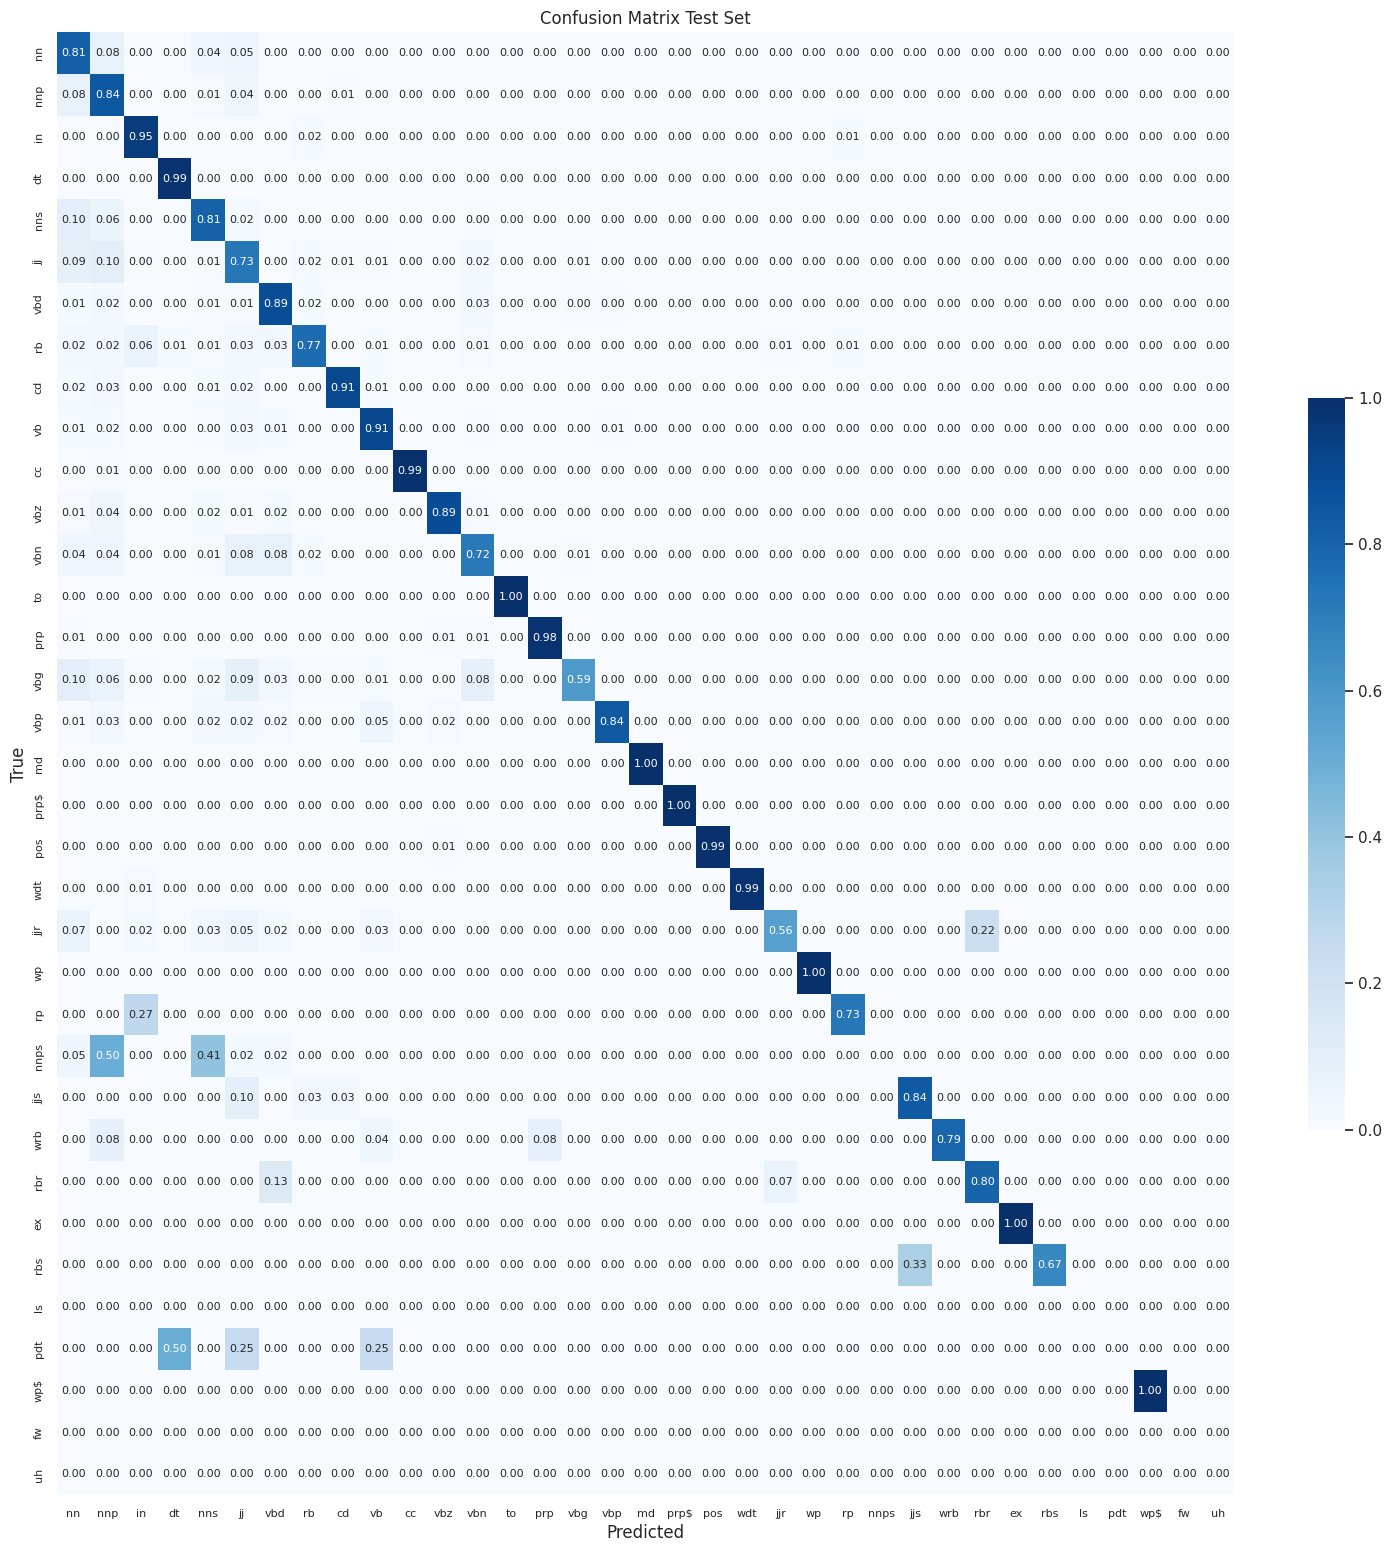

In [262]:
plot_confusion_matrix(y_test, y_pred_test, name="Test Set")

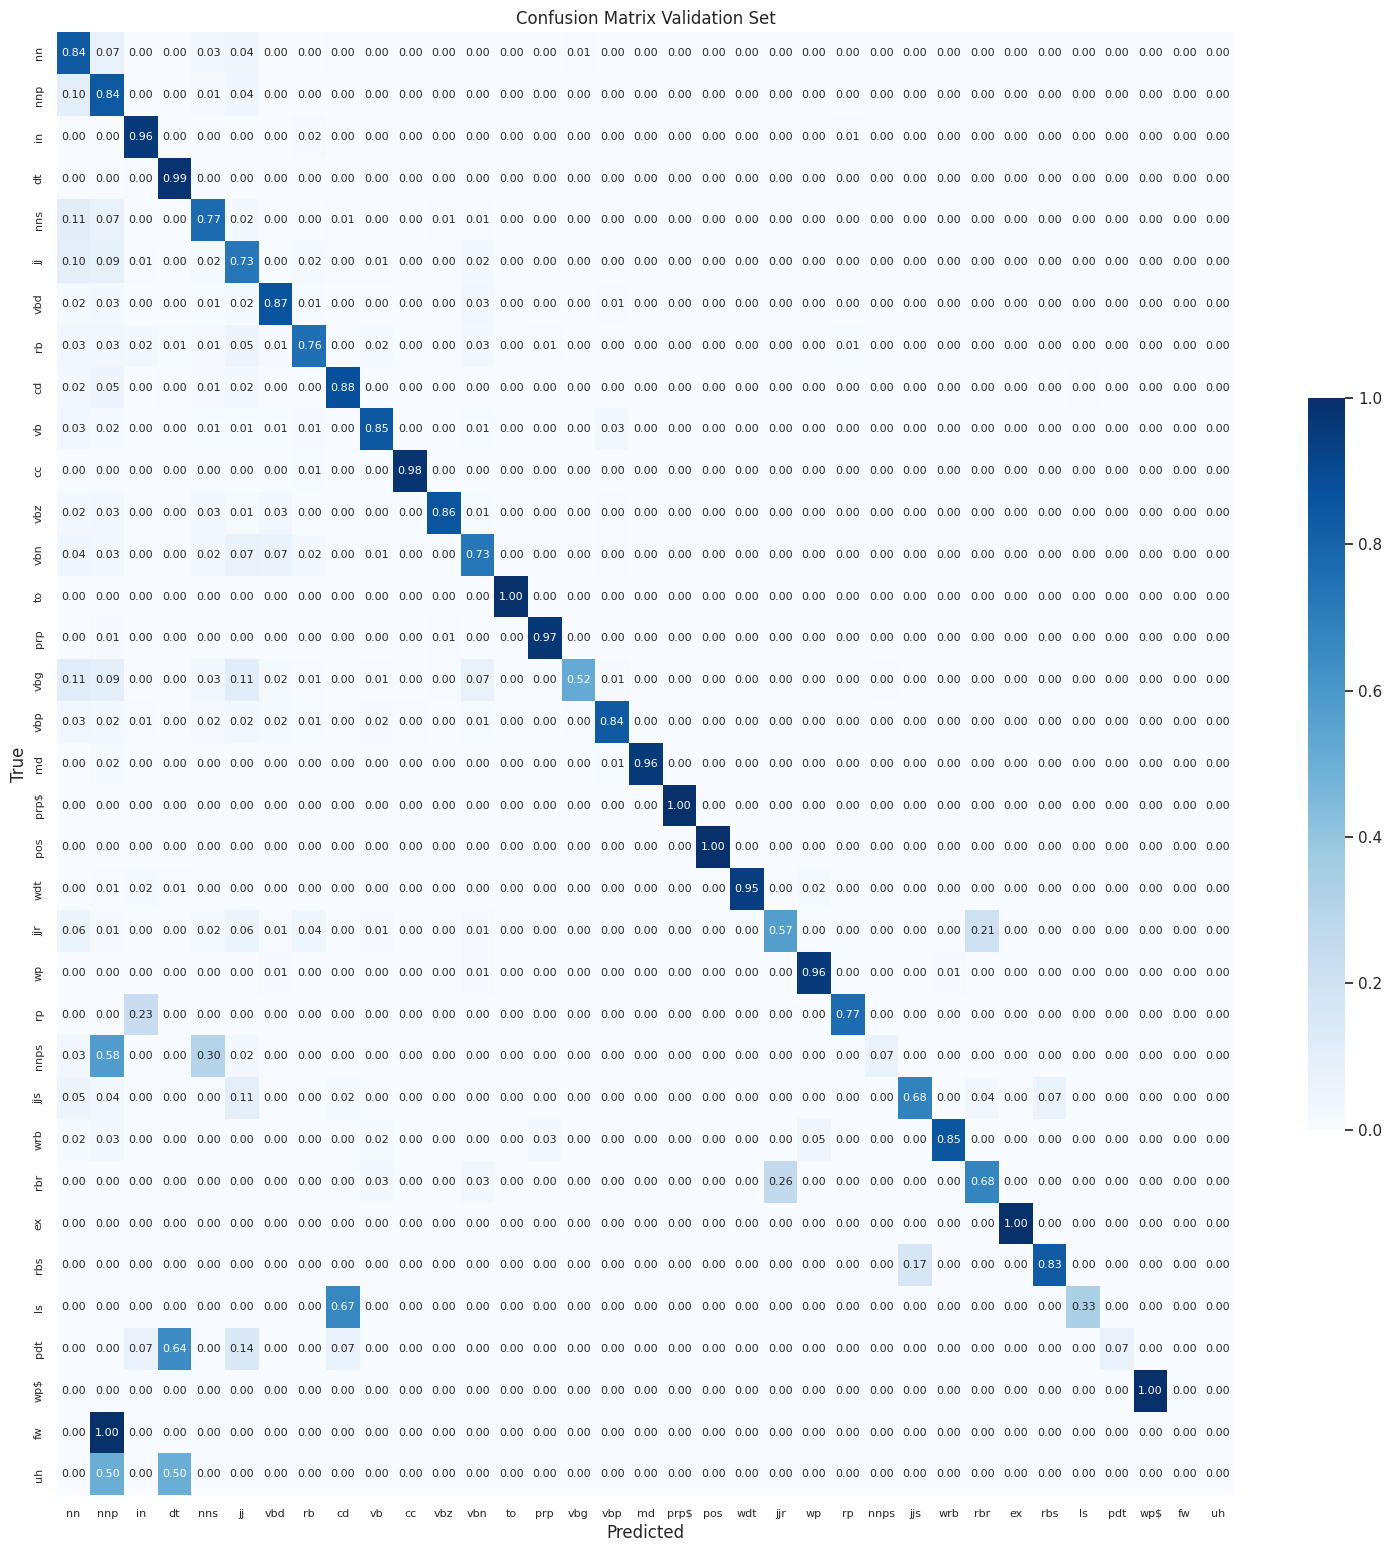

In [263]:
plot_confusion_matrix(y_test_val, y_pred_val, name="Validation Set")

#### Specific Misclassified Samples
Worst 30 classified sentences are inspected. The tables below shows that out-of-vocabulary 'OOV' tokens highly affected the score of the models. Also the "introductory elements" that ends with ":", abbreviations, and decimal numbers decrease the models' scores.

In [289]:
def get_worst_n_classified_sentences(x_test, y_test, y_pred, n):
    scores = {}

    # Get f1 score for each sentence
    for i in range(len(y_pred)):
        score = f1_score(
            y_pred[i],
            y_test[i],
            labels=allowed_tokens,
            zero_division=0,
            average="macro",
        )
        scores[x_test[i]] = score
    # Put the scores into a df
    scores_df = pd.DataFrame(scores.items(), columns=["Sentence", "Score"])
    scores_df.sort_values(by=["Score"], ascending=True, inplace=True)
    return scores_df.iloc[:n]

In [292]:
# Inspect the worst classified sentences in Test Set
decoded_x_test = tokenizer.sequences_to_texts(text_test)
get_worst_n_classified_sentences(decoded_x_test, y_test, y_pred_test, 30)

,Sentence,Score
78,OOV and OOV : OOV OOV OOV OOV OOV OOV OOV OOV ...,0.000000
456,"OOV inc . -lrb- chandler , ariz. -rrb- -- OOV ...",0.022857
404,average daily trading volume : OOV shares OOV ...,0.022857
86,OOV : OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV ...,0.028571
71,energy : OOV OOV OOV OOV OOV OOV OOV OOV OOV O...,0.028571
355,markets -- OOV OOV OOV OOV OOV OOV OOV OOV OOV...,0.028571
357,"dow jones industrials 2645.90 , up OOV ; trans...",0.041270
401,business : savings and loan OOV OOV OOV OOV OO...,0.047619
70,in other commodity markets yesterday : OOV OOV...,0.057143
356,stocks : volume OOV shares . OOV OOV OOV OOV O...,0.057143


In [293]:
# Inspect the worst classified sentences in Test Set
decoded_x_val = tokenizer.sequences_to_texts(text_val)
get_worst_n_classified_sentences(decoded_x_val, y_test_val, y_pred_val, 30)

,Sentence,Score
611,OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV OO...,0.000000
1197,elsewhere : OOV OOV OOV OOV OOV OOV OOV OOV OO...,0.000000
1167,corporate issues OOV OOV OOV OOV OOV OOV OOV O...,0.000000
744,OOV : OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV ...,0.000000
144,OOV report : OOV OOV OOV OOV OOV OOV OOV OOV O...,0.000000
1154,treasury securities OOV OOV OOV OOV OOV OOV OO...,0.019048
856,OOV co . -lrb- japan -rrb- -- OOV OOV OOV OOV ...,0.021429
869,mitsubishi OOV co . -lrb- japan -rrb- -- OOV O...,0.022857
259,source : OOV OOV -lrb- OOV . -rrb- inc . OOV O...,0.022857
874,OOV OOV corp . -lrb- japan -rrb- -- OOV OOV OO...,0.022857


## Results

This section will be written later.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End